# Intersecting a radar grid with CMLs

Comparing rainfall values with path integrated rainfall estimates from commercial microwave links between a wa

In [1]:
import matplotlib.pyplot as plt
import xarray as xr

import poligrain as plg

### Load example data

In [2]:
ds_cmls = xr.open_dataset("../../tests/test_data/openMRG_CML_180minutes.nc")

In [3]:
ds_radar = xr.open_dataset("../../tests/test_data/openMRG_Radar_180minutes.nc")

## Calculate intersection weights

Note that the intersection weights are stored as `sparse.arrays` in a `xarray.DataArray` because the matrix of intersection weights for each CMLs, based on the radar grid, contains mostly zeros. Hence, we can save a lot of space. For large CML networks this is crucial because storing thousands of intersection weight matrices, one for each CML, easily eats up 10s of GBs of memory.

Note that this calculation is fairly fast, i.e. approx. 2 seconds for 500 CMLs.

In [4]:
%%time
da_intersect_weights = plg.spatial.calc_sparse_intersect_weights_for_several_cmls(
    x1_line=ds_cmls.site_0_lon.values,
    y1_line=ds_cmls.site_0_lat.values,
    x2_line=ds_cmls.site_1_lon.values,
    y2_line=ds_cmls.site_1_lat.values,
    cml_id=ds_cmls.cml_id.values,
    x_grid=ds_radar.lon.values,
    y_grid=ds_radar.lat.values,
    grid_point_location="center",
)

CPU times: user 585 ms, sys: 10.4 ms, total: 595 ms
Wall time: 609 ms


In [5]:
da_intersect_weights.isel(cml_id=0)

Format,coo
Data Type,float64
Shape,"(48, 37)"
nnz,1
Density,0.0005630630630630631
Read-only,True
Size,24
Storage ratio,0.00


## Plot intersection weights and CML path

Note that the lon-lat of the radar grid have been rounded in this example dataset and hence there are some strange pixel size, stemming from the non-equidistant lon-lat grids of the original radar data.

(11.833089999999999, 12.00378)

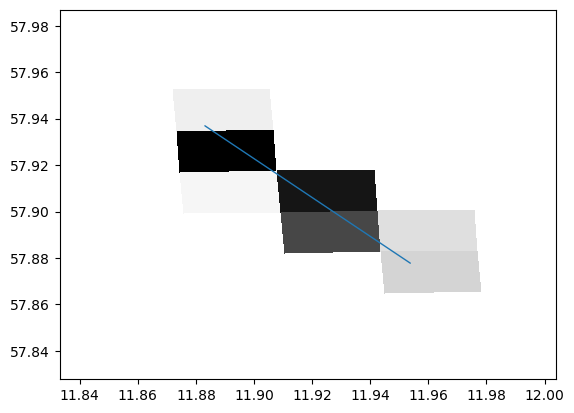

In [6]:
i = 10202
cml = ds_cmls.sel(cml_id=i)
plt.pcolormesh(
    ds_radar.lon.values,
    ds_radar.lat.values,
    da_intersect_weights.sel(cml_id=i).to_numpy(),
    cmap="Greys",
)

plg.plot_map.plot_lines(ds_cmls.sel(cml_id=i), ax=plt.gca())

plt.ylim(
    min(cml.site_0_lat.values, cml.site_1_lat.values) - 0.05,
    max(cml.site_0_lat.values, cml.site_1_lat.values) + 0.05,
)
plt.xlim(
    min(cml.site_0_lon.values, cml.site_1_lon.values) - 0.05,
    max(cml.site_0_lon.values, cml.site_1_lon.values) + 0.05,
)

## Get time series of radar rainfall along CML for each CML

This is internally done via a `sparase.tensordot` product, which is very fast, given that the intersection weights are also stored as `sparse.arrays`. The convenience funtion from `poligrain` used here, also takes care of adding the correct coordinates to the `xarray.DataArray` that is returned.

Note that this calculation is very fast and can be done with a large number of CMLs and a much longer period of radar data. 

In [7]:
%%time

da_radar_along_cmls = plg.spatial.get_grid_time_series_at_intersections(
    grid_data=ds_radar.rainfall_amount,
    intersect_weights=da_intersect_weights,
)

CPU times: user 320 ms, sys: 7.6 ms, total: 327 ms
Wall time: 328 ms


In [8]:
da_radar_along_cmls

<xarray.DataArray (time: 36, cml_id: 364)>
array([[5.45577289e-02, 1.29376820e-01, 5.15058173e-02, ...,
        4.86375435e-04, 2.60098642e-01, 7.85087184e-02],
       [4.86246270e-02, 4.86246443e-04, 4.86246236e-04, ...,
        2.68530211e-02, 4.86150392e-04, 4.86179854e-04],
       [4.86246236e-04, 4.86246443e-04, 4.86246236e-04, ...,
        4.86375435e-04, 4.86150392e-04, 4.86179854e-04],
       ...,
       [1.22139538e-02, 4.86246443e-04, 1.15307163e-01, ...,
        4.86375435e-04, 5.55353035e-02, 5.13666248e-02],
       [2.17198235e-01, 3.44236153e-01, 6.86841139e-01, ...,
        4.86375435e-04, 7.50213222e-02, 2.72055320e-01],
       [1.08856978e-02, 3.06800794e-01, 3.06800653e-02, ...,
        3.92748636e-02, 1.30498263e-01, 5.51433563e-02]])
Coordinates:
  * time     (time) datetime64[ns] 2015-08-27T00:20:00 ... 2015-08-27T03:15:00
  * cml_id   (cml_id) int64 10001 10002 10003 10004 ... 10361 10362 10363 10364

In [9]:
# The following show how you write the data to a NetCDF to use it somewhere else.
#
# da_radar_along_cmls.to_dataset(name='rainfall_amount').to_netcdf(
#    '..poligrain/tests/test_data/openMRG_example_path_averaged_reference_data.nc',
#    encoding={'rainfall_amount': {'zlib': True}}
# )

## Plot radar along CML vs. TL

We set non-meaningfull RSL and TSL values to NaN.

Here we only plot radar rain rates vs TL. For plotting CML-derived rain rates, processing has to be done first. But the comparison with TRSL already shows the fit between CML attenuation data and rainfall data.

In [10]:
ds_cmls["tsl"] = ds_cmls.tsl.where(ds_cmls.tsl < 100)
ds_cmls["rsl"] = ds_cmls.rsl.where(ds_cmls.rsl > -99)

ds_cmls["trsl"] = ds_cmls.tsl - ds_cmls.rsl

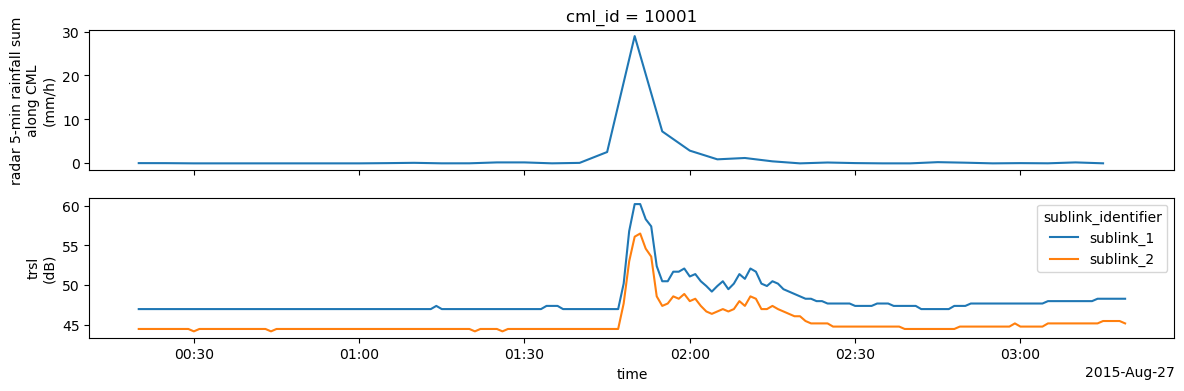

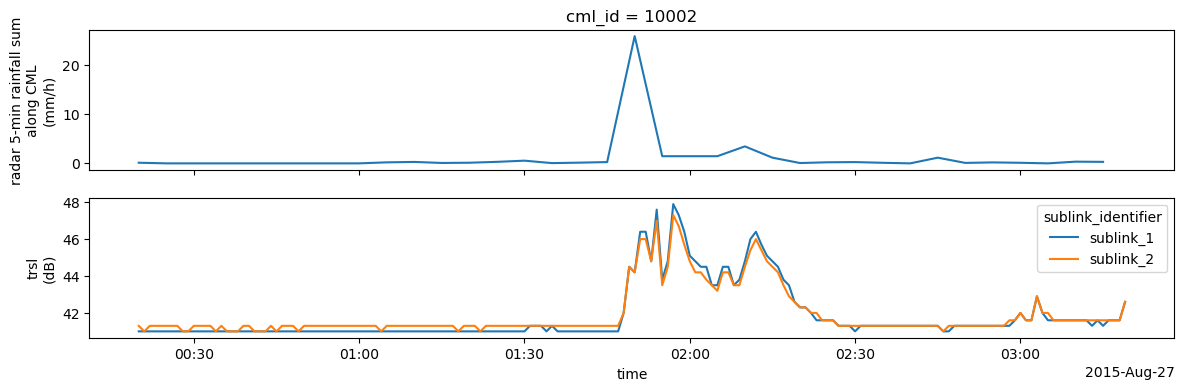

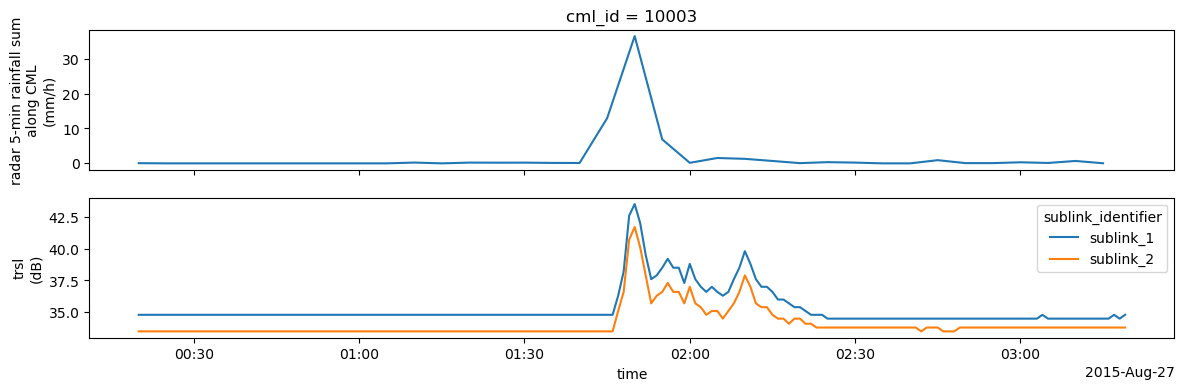

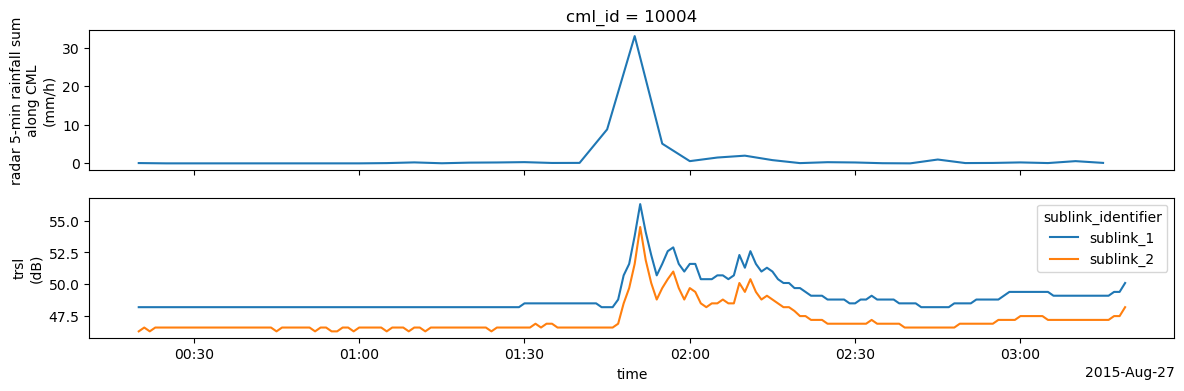

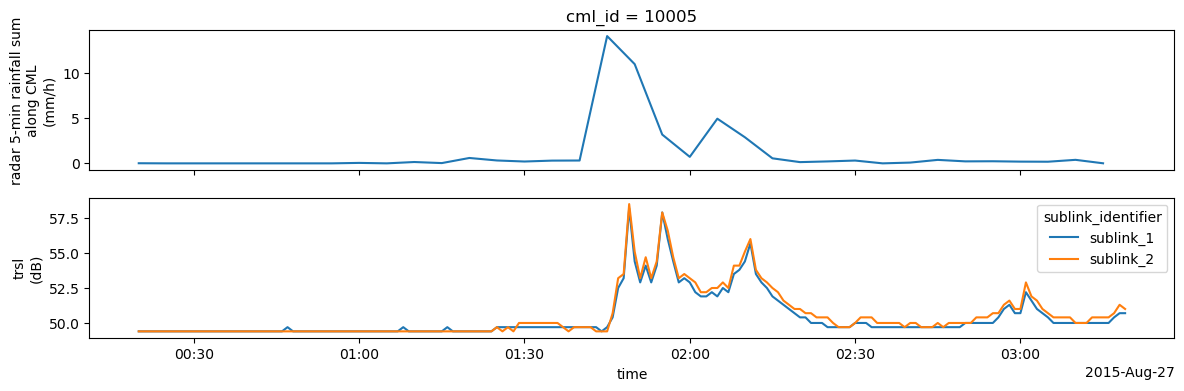

In [11]:
for i in range(5):
    fig, axs = plt.subplots(2, 1, figsize=(14, 4), sharex=True)
    da_radar_along_cmls.isel(cml_id=i).plot(ax=axs[0])
    ds_cmls.isel(cml_id=i).trsl.plot.line(x="time", ax=axs[1])
    axs[0].set_xlabel("")
    axs[0].set_ylabel("radar 5-min rainfall sum\nalong CML\n(mm/h)")
    axs[1].set_title("")
    axs[1].set_ylabel("trsl\n(dB)")

## Plot radar map and the results of the grid intersection

Here the 3 hour rainfall sum is shown for the radar rainfall field and the path integrated radar rainfall along each CML.

The path integrated radar rainfall on the bottom right plot can be used to compare the CML rainfall estimates to the radar rainfall.

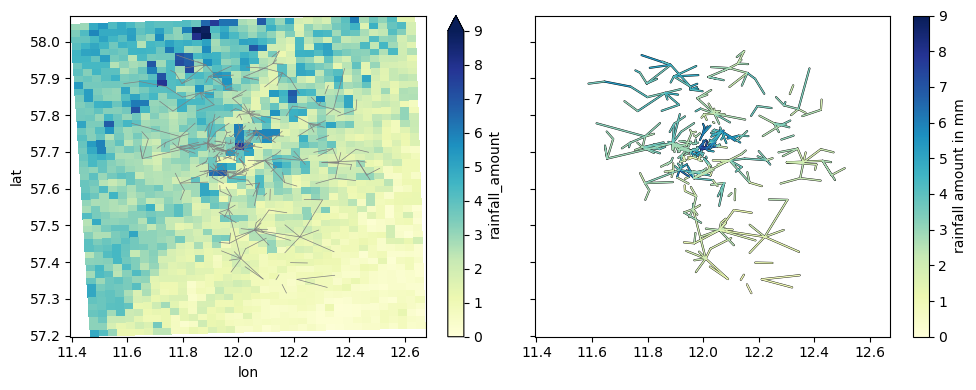

In [12]:
ds_cmls["radar_along_cmls"] = da_radar_along_cmls

fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True, sharex=True)

(ds_radar.rainfall_amount.sum(dim="time") / 12).plot(
    x="lon", y="lat", ax=ax[0], cmap="YlGnBu", vmin=0, vmax=9
)
plg.plot_map.plot_lines(ds_cmls, ax=ax[0], line_color="grey", line_width=0.5)

da_ralong = (
    ds_cmls.radar_along_cmls.sum(dim="time") / 12
)  # from intensity (mm/h) to amount (mm)
lines_radar_along_cml = da_ralong.plg.plot_cmls(
    pad_width=0.5, cmap="YlGnBu", ax=ax[1], vmin=0, vmax=9
)
plt.colorbar(lines_radar_along_cml, label="rainfall amount in mm")

plt.tight_layout()